# 10-5-3 network decay tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [393]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 754
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 0.54230642 -1.132221    0.3047863  -0.61860265  1.23116682  0.35500596
  -0.08708945 -0.14072873  0.58637626  0.87094336]
 [-0.08215991  0.89932458  0.10104486 -1.00831313  1.2062999  -1.15374041
  -1.41351605  1.08002172  0.57090965  1.31228227]
 [ 0.64131899  0.27537833  0.1026602   0.06952368 -0.53558272 -1.2147515
   0.82267616  1.40446175 -0.91479435  1.11225734]]


In [5]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [394]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

# Use A and B to make a dataset
def MakeTwoClustersDataset(A, B, mode, n=200, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes-1

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(bottom_dim)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))
            
        if mode == 1:
            if r == 0:
                training_input.append(B[r])
                training_output.append(A[r+2]+noise*np.random.normal(size=np.shape(A[r+2])))
        else:
            if r == 1:
                training_input.append(B[r])
                training_output.append(A[r+1]+noise*np.random.normal(size=np.shape(A[r+1])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [397]:
B = np.eye(2)
train = MakeTwoClustersDataset(A, B, mode=1)

In [396]:
B = np.eye(3)
train = MakeDataset(A, B)

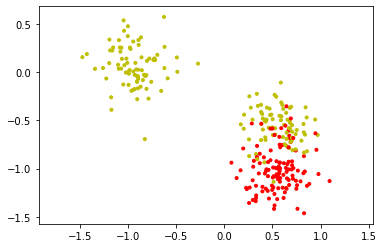

In [398]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

In [ ]:
[[-1.58184445  1.71892178 -1.50379764 -0.39564991  0.44717416]
 [ 2.0277381  -0.34614888 -0.36954289  0.2077977  -0.98580555]
 [-1.50992034 -1.18708687 -1.65698194  1.41050074  1.88135675]
 [ 1.52049605  2.64798354  0.25483025 -0.11230116  2.66694624]
 [ 0.66196554  1.10162277 -0.82164634  0.46311775  0.34017561]
 [-3.25360262  0.59212445 -1.55190346 -0.76230704  0.21900541]
 [-1.63606317  0.34484235 -1.28677285  0.71620644  0.78062613]
 [-0.20039312  0.34654465  0.48774932 -0.14120785  1.22591693]
 [-1.03582797  1.10317586  0.68756711  1.17044821  1.94904   ]
 [ 0.23015634 -2.10062628 -0.49378618 -0.69754107 -0.01639506]]
[[ 0.0528918  -0.900796  ]
 [-0.50253907 -1.01117998]
 [ 1.82100263  1.58280354]
 [ 5.23694724  0.33592539]
 [-0.53989873 -0.99135091]]

In [515]:
np.save('A.npy', A)

In [486]:
np.save('initial_weights_1.npy', initial_weights_1)

In [245]:
n_classes = 2

# Create a network
ffnet = FF.Network()

af = 'identity'#'logistic'
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))

cost = 'MSE'#'cross-entropy'
ffnet.SetCostFunction(cost)

#initial_weights_0 = deepcopy(ffnet.W[0])
#initial_weights_1 = deepcopy(ffnet.W[1])

for w in ffnet.W:
    print(w)

[[-1.58184445  1.71892178 -1.50379764 -0.39564991  0.44717416]
 [ 2.0277381  -0.34614888 -0.36954289  0.2077977  -0.98580555]
 [-1.50992034 -1.18708687 -1.65698194  1.41050074  1.88135675]
 [ 1.52049605  2.64798354  0.25483025 -0.11230116  2.66694624]
 [ 0.66196554  1.10162277 -0.82164634  0.46311775  0.34017561]
 [-3.25360262  0.59212445 -1.55190346 -0.76230704  0.21900541]
 [-1.63606317  0.34484235 -1.28677285  0.71620644  0.78062613]
 [-0.20039312  0.34654465  0.48774932 -0.14120785  1.22591693]
 [-1.03582797  1.10317586  0.68756711  1.17044821  1.94904   ]
 [ 0.23015634 -2.10062628 -0.49378618 -0.69754107 -0.01639506]]
[[ 0.0528918  -0.900796  ]
 [-0.50253907 -1.01117998]
 [ 1.82100263  1.58280354]
 [ 5.23694724  0.33592539]
 [-0.53989873 -0.99135091]]


In [525]:
ffnet.W[0] = initial_weights_0
ffnet.W[1] = initial_weights_1

In [528]:
w_decay= 0.0085
progress = ffnet.SGD(train[1].cpu().numpy(), train[0].cpu().numpy(), lrate=0.01, weight_decay=w_decay, bias_decay=0.0, epochs=10, batch_size=4, shuffle=False)

Epoch 0: Cost = 0.2252384950630805
Epoch 1: Cost = 0.06569330433092661
Epoch 2: Cost = 0.11476166360765756
Epoch 3: Cost = 0.18331804975281255
Epoch 4: Cost = 0.2357831346602621
Epoch 5: Cost = 0.26915358504006126
Epoch 6: Cost = 0.2901607199076176
Epoch 7: Cost = 0.30411191251809566
Epoch 8: Cost = 0.31394756289501496
Epoch 9: Cost = 0.3212303498794758


In [529]:
FF.ClassificationAccuracy(ffnet.FeedForward(train[1].cpu().numpy()), train[0].cpu().numpy())

0.8178571428571428

In [530]:
for w in ffnet.W:
    print(w)
    
for l in ffnet.lyr:
    print(l.b)

[[ 0.05693298 -0.04410096 -0.03754519 -0.04850979  0.00758691]
 [-0.05246726  0.07572529  0.07473392 -0.02371354 -0.01095774]
 [ 0.02275561 -0.01224615 -0.0053243  -0.02739505  0.00206712]
 [-0.00853662 -0.03196347 -0.03313721  0.10023671  0.00042996]
 [ 0.02324583  0.03730709  0.03720639 -0.12566292 -0.00073161]
 [-0.02929881 -0.0277116  -0.03548291  0.13009137  0.0027467 ]
 [ 0.04677373 -0.09698718 -0.09207728  0.07372848  0.01691595]
 [ 0.04720521  0.01485866  0.01524335 -0.13990776  0.00776399]
 [-0.02092722  0.0444121   0.03733781 -0.02867652 -0.01370434]
 [ 0.08206012  0.00172791  0.01136629 -0.191837    0.0083874 ]]
[[ 0.1395258   0.01144349]
 [-0.07813242  0.12812593]
 [-0.06405162  0.12975475]
 [-0.1788433  -0.27800592]
 [ 0.0230674  -0.01198397]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0.]


## Create a Neural Network

In [526]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = False
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.02)
net.learning_tau = 0.1
net.learn_biases = False

net.connections[0].M = torch.tensor(initial_weights_1).float().to(device)
net.connections[0].W = net.connections[0].M.transpose(1,0)

net.connections[1].M = torch.tensor(initial_weights_0).float().to(device)
net.connections[1].W = net.connections[1].M.transpose(1,0)

identity
identity


In [527]:
for c in net.connections:
    print(c.M)
    print(c.W)

tensor([[ 4.6037, -2.1674],
        [-1.0951,  1.8159],
        [-2.3668,  1.2040],
        [-2.4005, -3.4943],
        [-0.2133,  3.2979]], device='cuda:0')
tensor([[ 4.6037, -1.0951, -2.3668, -2.4005, -0.2133],
        [-2.1674,  1.8159,  1.2040, -3.4943,  3.2979]], device='cuda:0')
tensor([[-0.4661, -0.3091,  0.3557, -0.4444, -0.0937],
        [ 0.5837, -0.4023,  1.0733,  2.2816, -1.4394],
        [ 1.1073, -1.4278,  0.5108,  1.2044, -0.4449],
        [ 3.1882, -0.0422,  0.0900,  0.5836, -0.3253],
        [ 0.3106,  1.2689, -0.1310, -2.2121,  0.2245],
        [ 0.6402,  0.3976, -1.6709,  0.6795,  2.1964],
        [-0.7648, -1.1937, -0.5163, -0.8274,  2.9683],
        [-0.6743,  0.1284, -1.2894,  0.8021,  0.8560],
        [ 1.1452,  2.0719, -0.3085, -1.7817, -3.4571],
        [ 0.3436,  0.1398,  1.0015, -0.6341,  0.0705]], device='cuda:0')
tensor([[-0.4661,  0.5837,  1.1073,  3.1882,  0.3106,  0.6402, -0.7648, -0.6743,
          1.1452,  0.3436],
        [-0.3091, -0.4023, -1.4278, -

In [512]:
net.SetWeightDecay(0.03)
net.SetvDecay(0.0)
net.learning_blackout=1.0
net.blackout_interval=0.0
net.Learn(train[0], train[1], T=4., dt=0.001, epochs=1, batch_size=4, shuffle=False)

FloatProgress(value=0.0, max=280.0)

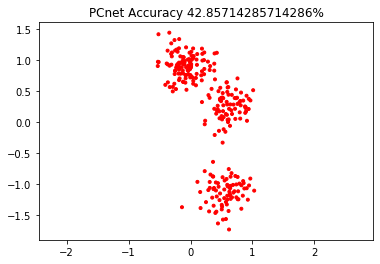

In [513]:
mu0 = net.Generate(15., train[1].to(device), dt=0.001)
#acc = FF.ClassificationAccuracy(NN.logistic(mu0).cpu().numpy(), train[0].cpu().numpy())
acc = FF.ClassificationAccuracy(mu0.cpu().numpy(), train[0].cpu().numpy())
#ClassPlot(train[1], labels=NN.logistic(mu0.cpu()), idx=(0,1));
ClassPlot(train[1].cpu(), labels=mu0.cpu(), idx=(0,1))

plt.title('PCnet Accuracy '+str(acc*100)+'%');

# Test Generation

In [531]:
classes = torch.eye(n_classes).to(device)
print(classes)

tensor([[1., 0.],
        [0., 1.]], device='cuda:0')


In [532]:
netx = net
netx.connections[1].SetM(ffnet.W[0])
netx.connections[1].SetW(ffnet.W[0].T)
netx.connections[0].SetM(ffnet.W[1])
netx.connections[0].SetW(ffnet.W[1].T)
netx.layers[1].SetBias(ffnet.lyr[1].b)
netx.layers[0].SetBias(ffnet.lyr[2].b)

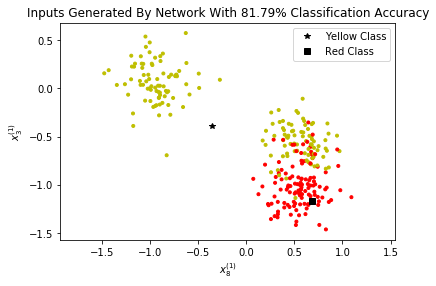

In [533]:
netx.Reset()
netx.SetvDecay(0.01)
z2 = netx.Predict(10., classes.to(device), dt=0.001)

lgnd = ['Yellow Class', 'Red Class']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)

plt.plot(np.array(z2[0,idx[0]].cpu()), np.array(z2[0,idx[1]].cpu()), 'k*')
plt.plot(np.array(z2[1,idx[0]].cpu()), np.array(z2[1,idx[1]].cpu()), 'ks')
plt.xlabel('$x_8^{(1)}$')
plt.ylabel('$x_3^{(1)}$')
plt.legend(lgnd)

plt.title('Inputs Generated By Network With 81.79% Classification Accuracy')
plt.savefig("two_clusters_with_decay.pdf", format='pdf')

#plt.title('Inputs Generated By Network With 100% Classification Accuracy')
#plt.savefig("two_clusters_no_decay.pdf", format='pdf')

# Older stuff

In [104]:
pcweight_nondecay_first = np.matrix.flatten(np.asarray(nodecay_PC.connections[1].M.cpu()))
ffweight_nodecay_first = np.matrix.flatten(np.asarray(nodecay_FF.W[0]))
pcweight_nondecay_second = np.matrix.flatten(np.asarray(nodecay_PC.connections[0].M.cpu()))
ffweight_nodecay_second = np.matrix.flatten(np.asarray(nodecay_FF.W[1]))

pcweight_nondecay = np.concatenate((pcweight_nondecay_first, pcweight_nondecay_second))
ffweight_nodecay = np.concatenate((ffweight_nodecay_first, ffweight_nodecay_second))

In [105]:
pcweight_decay_first = np.matrix.flatten(np.asarray(decay_PC.connections[1].M.cpu()))
ffweight_decay_first = np.matrix.flatten(np.asarray(decay_FF.W[0]))
pcweight_decay_second = np.matrix.flatten(np.asarray(decay_PC.connections[0].M.cpu()))
ffweight_decay_second = np.matrix.flatten(np.asarray(decay_FF.W[1]))

pcweight_decay = np.concatenate((pcweight_decay_first, pcweight_decay_second))
ffweight_decay = np.concatenate((ffweight_decay_first, ffweight_decay_second))

In [106]:
print(pcweight_nondecay)
print(ffweight_nodecay)

[-6.30912483e-01 -1.84495926e+00  4.39332873e-01 -1.18715215e+00
 -5.56977808e-01 -5.39279401e-01 -4.60125417e-01 -2.80913532e-01
 -1.06863737e+00 -3.46348941e-01  6.62652731e-01  3.83042961e-01
  6.37929559e-01  1.16422415e+00  2.65895039e-01  6.89486206e-01
 -3.70946117e-02  1.13964751e-01  1.27327025e+00  2.05914527e-01
  4.17660683e-01  3.18752527e+00  1.54991758e+00  1.03334093e+00
  7.25745082e-01  1.10635066e+00 -9.29445744e-01  1.08688235e+00
  2.19896436e+00  1.75059110e-01 -1.17905569e+00 -3.11078548e+00
 -5.35903931e-01 -2.21323037e+00 -1.00202835e+00  9.49949801e-01
 -4.85721268e-02  1.33683360e+00  1.84269357e+00  1.77514896e-01
 -4.03169483e-01 -1.05933702e+00  7.67405927e-01 -6.83973849e-01
 -4.04143721e-01  3.60595107e-01 -3.01838905e-01 -4.93051082e-01
  5.55210352e-01  1.17100924e-01  3.12205839e+00  2.15065050e+00
  2.21256569e-01  1.88052456e-03 -3.33021358e-02 -5.84405541e-01
  1.28762513e-01  2.48929173e-01  2.88755536e-01 -1.74277294e+00
 -1.26062357e+00 -7.44052

In [107]:
print(pcweight_decay)
print(ffweight_decay)

[-0.10079524 -0.1104819  -0.07758839 -0.43048275  0.07384961  0.19876489
 -0.1139195  -0.06242726  0.05095066 -0.21375778  0.15785995 -0.02367613
 -0.12520331 -0.12025901 -0.07896282  0.10296928 -0.01269856 -0.0160467
  0.1005711  -0.09229706 -0.16491453  0.01656573  0.10688389  0.055726
  0.09286949 -0.12928474  0.01648323  0.15443796  0.23676515  0.02922751
 -0.11757454 -0.1528884   0.07904499 -0.05988378 -0.03872586  0.0610662
 -0.15558688  0.03485556  0.08303472 -0.17615941 -0.08058566 -0.19894108
  0.03589525 -0.15175246 -0.07363413  0.07758368  0.17490748 -0.10385641
 -0.05188768  0.10537903  0.4337837  -0.04312869 -0.29104096  0.17965192
 -0.4444197   0.15567064 -0.3808408  -0.03739583 -0.0237476  -0.27040708
 -0.45424247 -0.39286828 -0.03996909 -0.21427585  0.3806186 ]
[-1.23503016e-01 -6.19963263e-01  5.99908420e-01 -7.78404704e-01
 -9.37535963e-02  1.34875027e-01 -1.48594411e-01  1.19700431e-01
 -5.92177129e-01 -3.39422627e-01  3.27309923e-01  2.10989507e-01
  3.43271285e-01 

In [108]:
print(np.dot(pcweight_nondecay, pcweight_decay) / (np.linalg.norm(pcweight_nondecay)*np.linalg.norm(pcweight_decay)))

0.46529037


In [109]:
print(np.dot(ffweight_decay, pcweight_decay) / (np.linalg.norm(ffweight_decay)*np.linalg.norm(pcweight_decay)))

0.45296573570021637


In [110]:
print(np.dot(ffweight_decay, pcweight_nondecay) / (np.linalg.norm(ffweight_decay)*np.linalg.norm(pcweight_nondecay)))

0.8884050605748361


In [111]:
print(np.dot(ffweight_nodecay, pcweight_decay) / (np.linalg.norm(ffweight_nodecay)*np.linalg.norm(pcweight_decay)))

0.3719636705990848


In [112]:
print(np.dot(ffweight_nodecay, pcweight_nondecay) / (np.linalg.norm(ffweight_nodecay)*np.linalg.norm(pcweight_nondecay)))

0.890368729779978


In [82]:
nodecay_PC = deepcopy(net)
nodecay_FF = deepcopy(ffnet)

In [51]:
decay_PC = deepcopy(net)
decay_FF = deepcopy(ffnet)

In [98]:
print(np.dot(ffweight_decay_first, pcweight_decay_first) / (np.linalg.norm(ffweight_decay_first)*np.linalg.norm(pcweight_decay_first)))

0.43158198970894585


In [100]:
print(np.dot(ffweight_nodecay_first, pcweight_nondecay_first) / (np.linalg.norm(ffweight_nodecay_first)*np.linalg.norm(pcweight_nondecay_first)))

0.9296117742990068


In [102]:
print(np.dot(ffweight_decay_second, pcweight_decay_second) / (np.linalg.norm(ffweight_decay_second)*np.linalg.norm(pcweight_decay_second)))

0.68899980828065


In [101]:
print(np.dot(ffweight_nodecay_second, pcweight_nondecay_second) / (np.linalg.norm(ffweight_nodecay_second)*np.linalg.norm(pcweight_nondecay_second)))

0.9042142484492369


In [11]:
netx = net
netx.connections[1].SetM(ffnet.W[0])
netx.connections[1].SetW(ffnet.W[0].T)
netx.connections[0].SetM(ffnet.W[1])
netx.connections[0].SetW(ffnet.W[1].T)
netx.layers[1].SetBias(ffnet.lyr[1].b)
netx.layers[0].SetBias(ffnet.lyr[2].b)

In [12]:
for c in netx.connections:
    print(c.M)
    print(c.W)

tensor([[-0.2456,  0.1593,  0.0441],
        [-0.0188, -0.1228,  0.1546],
        [ 0.0478,  0.0578, -0.1081],
        [ 0.0291, -0.1118,  0.0989],
        [-0.0786,  0.0486,  0.0167]], device='cuda:0')
tensor([[-0.2456, -0.0188,  0.0478,  0.0291, -0.0786],
        [ 0.1593, -0.1228,  0.0578, -0.1118,  0.0486],
        [ 0.0441,  0.1546, -0.1081,  0.0989,  0.0167]], device='cuda:0')
tensor([[ 0.0691,  0.0077, -0.0150, -0.0065,  0.0222],
        [-0.0385, -0.1190,  0.0838, -0.0754, -0.0143],
        [-0.0934, -0.0353,  0.0367, -0.0084, -0.0304],
        [-0.0406, -0.0495,  0.0384, -0.0272, -0.0138],
        [ 0.0896,  0.0523, -0.0473,  0.0207,  0.0294],
        [ 0.0727,  0.0275, -0.0286,  0.0065,  0.0236],
        [ 0.1430, -0.0233, -0.0053, -0.0405,  0.0452],
        [ 0.0447, -0.0912,  0.0536, -0.0705,  0.0127],
        [ 0.1391, -0.0653,  0.0229, -0.0687,  0.0432],
        [-0.1261,  0.0693, -0.0274,  0.0693, -0.0390]], device='cuda:0')
tensor([[ 0.0691, -0.0385, -0.0934, -0.0406,  